In [13]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
import h5py as h5

import astropy.units as u

from joblib import Parallel, delayed
from lowda import load_galaxy
import lowda as lwd

import diptest as dt

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

# dip test 1D

In [35]:
dat_uni = np.random.normal(size=1000)
dat_bi = np.concatenate([np.random.normal(size=500), np.random.normal(loc=4, scale=0.5, size=500)])

In [42]:
dip0, pval0 = dt.diptest(dat_uni)
print(dip0, pval0)

dip1, pval1 = dt.diptest(dat_bi*0.3)
print(dip1, pval1)

0.00746886537996269 0.9906129210101384
0.06556335353574011 0.0


(array([  0.,   0.,   0.,   1.,   3.,   7.,  14.,  18.,  30.,  54.,  59.,
         72.,  65.,  57.,  49.,  36.,  15.,  21.,  39.,  95., 134., 110.,
         78.,  32.,   9.,   2.,   0.,   0.,   0.,   0.]),
 array([-4.        , -3.66666667, -3.33333333, -3.        , -2.66666667,
        -2.33333333, -2.        , -1.66666667, -1.33333333, -1.        ,
        -0.66666667, -0.33333333,  0.        ,  0.33333333,  0.66666667,
         1.        ,  1.33333333,  1.66666667,  2.        ,  2.33333333,
         2.66666667,  3.        ,  3.33333333,  3.66666667,  4.        ,
         4.33333333,  4.66666667,  5.        ,  5.33333333,  5.66666667,
         6.        ]),
 [<matplotlib.patches.Polygon at 0x14dbb2cf1f90>])

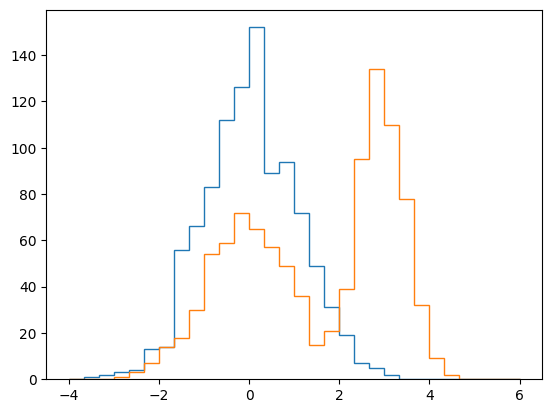

In [27]:
plt.hist(dat_uni, bins=np.linspace(-4, 6, 31), histtype='step')
plt.hist(dat_bi, bins=np.linspace(-4, 6, 31), histtype='step')

# dip test 2D

In [118]:
# Generate samples
dat_uni = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 1000)

# dat_bi0 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 500)
# dat_bi1 = np.random.multivariate_normal([3, 1], [[0.3, 0], [0, 0.7]], 500)
# dat_bi = np.concatenate([dat_bi0, dat_bi1])

dat_bi0 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 500)
dat_bi1 = np.random.multivariate_normal([2.7, 0], [[1, 0], [0, 1]], 500)
dat_bi = np.concatenate([dat_bi0, dat_bi1])

dat_ebi0 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 500)
dat_ebi1 = np.random.multivariate_normal([5, 1], [[0.3, 0], [0, 0.7]], 500)
dat_ebi = np.concatenate([dat_ebi0, dat_ebi1])

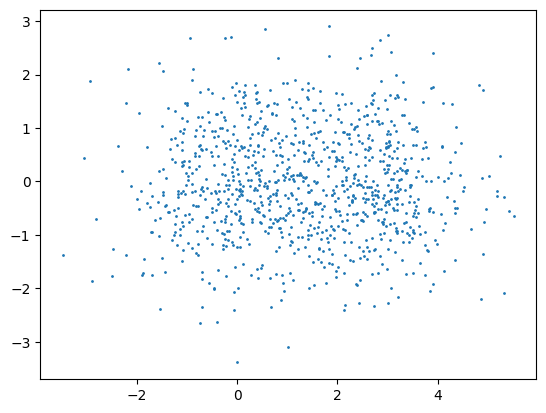

In [119]:
# plt.scatter(dat_uni[:,0], dat_uni[:,1], s=1)
plt.scatter(dat_bi[:,0], dat_bi[:,1], s=1)
# plt.scatter(dat_ebi[:,0], dat_ebi[:,1], s=1)

In [109]:
%%time
dip_uni = np.zeros(dat_uni.shape[0])
p_uni = np.zeros(dat_uni.shape[0])
for i,pt in enumerate(dat_uni):
    dist = np.linalg.norm(dat_uni - pt, axis=1)
    dip_uni[i], p_uni[i] = dt.diptest(dist)

CPU times: user 115 ms, sys: 58 µs, total: 115 ms
Wall time: 115 ms


In [110]:
%%time
dip_bi = np.zeros(dat_bi.shape[0])
p_bi = np.zeros(dat_bi.shape[0])
for i,pt in enumerate(dat_bi):
    dist = np.linalg.norm(dat_bi - pt, axis=1)
    dip_bi[i], p_bi[i] = dt.diptest(dist)

CPU times: user 114 ms, sys: 0 ns, total: 114 ms
Wall time: 114 ms


In [111]:
%%time
dip_ebi = np.zeros(dat_ebi.shape[0])
p_ebi = np.zeros(dat_ebi.shape[0])
for i,pt in enumerate(dat_ebi):
    dist = np.linalg.norm(dat_ebi - pt, axis=1)
    dip_ebi[i], p_ebi[i] = dt.diptest(dist)

CPU times: user 111 ms, sys: 912 µs, total: 112 ms
Wall time: 112 ms


uni < 0.05: 0.0
bi < 0.05: 0.012
ebi < 0.05: 0.935


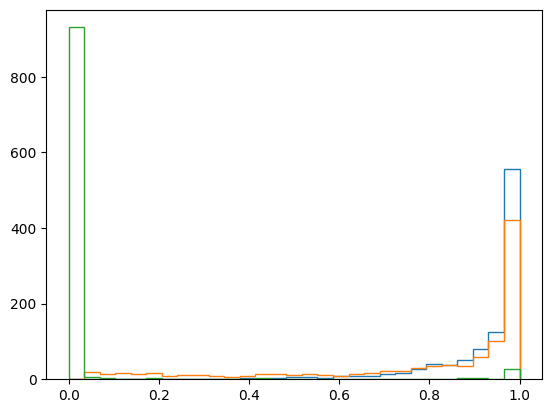

In [112]:
plt.hist(p_uni, histtype='step', bins=np.linspace(0, 1, 30))
plt.hist(p_bi, histtype='step', bins=np.linspace(0, 1, 30))
plt.hist(p_ebi, histtype='step', bins=np.linspace(0, 1, 30))

print('uni < 0.05:', np.sum(p_uni < 0.05)/len(p_uni))
print('bi < 0.05:', np.sum(p_bi < 0.05)/len(p_bi))
print('ebi < 0.05:', np.sum(p_ebi < 0.05)/len(p_ebi))

(array([  0.,  50.,  16.,  10.,  14.,  15.,  25.,  29.,  25.,  32.,  49.,
         67.,  68.,  84.,  86.,  95., 104.,  99.,  58.,  44.,  30.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.00517241, 0.01034483, 0.01551724, 0.02068966,
        0.02586207, 0.03103448, 0.0362069 , 0.04137931, 0.04655172,
        0.05172414, 0.05689655, 0.06206897, 0.06724138, 0.07241379,
        0.07758621, 0.08275862, 0.08793103, 0.09310345, 0.09827586,
        0.10344828, 0.10862069, 0.1137931 , 0.11896552, 0.12413793,
        0.12931034, 0.13448276, 0.13965517, 0.14482759, 0.15      ]),
 [<matplotlib.patches.Polygon at 0x14dbb060acb0>])

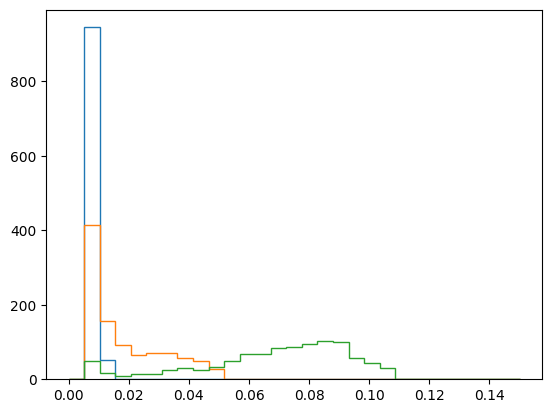

In [75]:
plt.hist(dip_uni, histtype='step', bins=np.linspace(0, 0.15, 30))
plt.hist(dip_bi, histtype='step', bins=np.linspace(0, 0.15, 30))
plt.hist(dip_ebi, histtype='step', bins=np.linspace(0, 0.15, 30))

In [50]:
%%time
dip = np.zeros(dat_bi.shape[0])
for i,pt in enumerate(dat_bi):
    dist = np.linalg.norm(dat_bi - pt, axis=1)
    dip[i] = dt.dipstat(dist)

CPU times: user 84.1 ms, sys: 590 µs, total: 84.7 ms
Wall time: 84.4 ms


(array([334., 104.,  69.,  88.,  70.,  94.,  84.,  69.,  55.,  33.]),
 array([0.00522898, 0.00944794, 0.01366691, 0.01788587, 0.02210483,
        0.02632379, 0.03054276, 0.03476172, 0.03898068, 0.04319964,
        0.04741861]),
 <BarContainer object of 10 artists>)

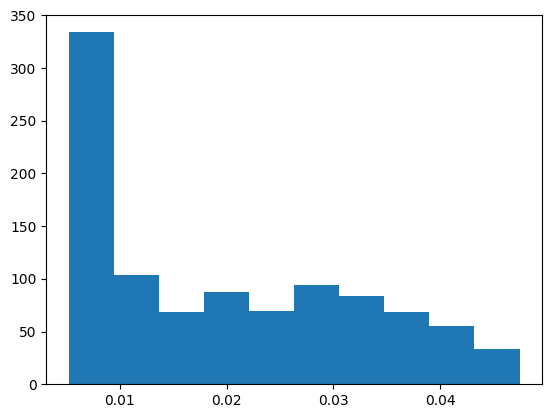

In [51]:
plt.hist(dip)

# tests

In [160]:
def get_dip_p(mean0, mean1, cov0, cov1, nsamp0=500, nsamp1=500, pval0=0.05):
    np.random.seed(69)
    dat0 = np.random.multivariate_normal(mean0, cov0, nsamp0)
    dat1 = np.random.multivariate_normal(mean1, cov1, nsamp1)
    dat = np.concatenate([dat0, dat1])
    
    dip = np.zeros(dat.shape[0])
    pval = np.zeros(dat.shape[0])
    
    for i,pt in enumerate(dat):
        dist = np.linalg.norm(dat-pt, axis=1)
        dip[i], pval[i] = dt.diptest(dist)
    
    return np.median(dip), np.sum(pval < pval0)/len(pval)

In [218]:
mean0 = [0, 0]
cov0 = [[1, 0], [0, 1]]
cov1 = [[1, 0], [0, 1]]

mu_list = np.linspace(0, 20, 200)
dip_list = np.zeros_like(mu_list)
fp_list = np.zeros_like(mu_list)
for i,mu in enumerate(tqdm(mu_list, leave=True, position=0)):
    mean1 = [mu, 0]
    dip_list[i], fp_list[i] = get_dip_p(mean0, mean1, cov0, cov1)

100%|██████████| 200/200 [00:24<00:00,  8.18it/s]


(0.0, 0.2)

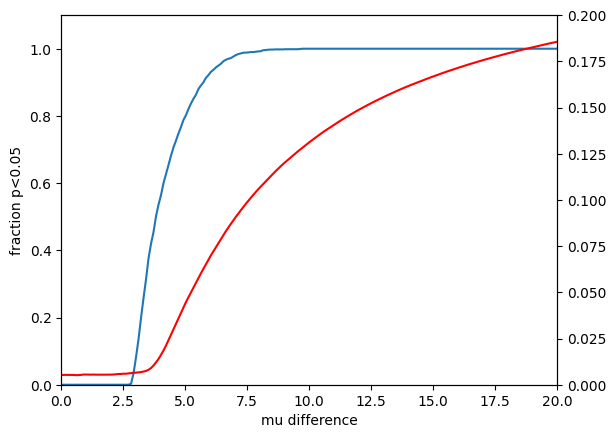

In [216]:
fig, ax = plt.subplots(1, 1)
ax.set(xlim=(0, 20))
ax.set(ylim=(0, 1.1))
ax.plot(mu_list, fp_list)
ax.set(ylabel='fraction p<0.05', xlabel='mu difference')

ax2 = ax.twinx()
ax2.plot(mu_list, dip_list, c='r')
ax2.set_ylim(0, 0.2)

In [168]:
mean0 = [0, 0]
mean1 = [2, 0]
cov0 = [[1, 0], [0, 1]]

sigma_list = np.logspace(np.log10(0.01), np.log10(3), 200)
dip_list = np.zeros_like(sigma_list)
fp_list = np.zeros_like(sigma_list)
for i,sigma in enumerate(tqdm(sigma_list)):
    cov1 = [[sigma, 0], [0, sigma]]
    dip_list[i], fp_list[i] = get_dip_p(mean0, mean1, cov0, cov1)

100%|██████████| 200/200 [00:24<00:00,  8.17it/s]


(0.0, 0.2)

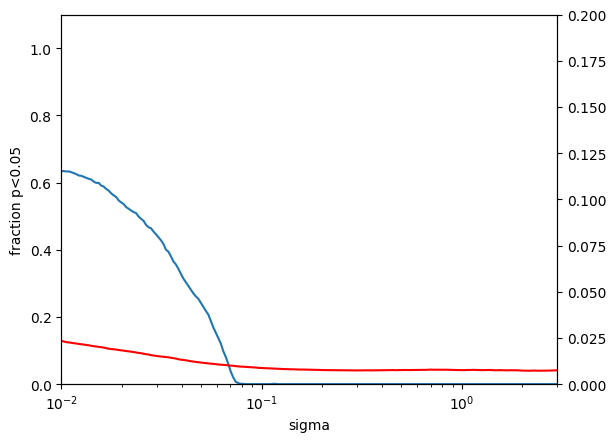

In [170]:
fig, ax = plt.subplots(1, 1)
ax.set(xlim=(0.01, 3), xscale='log')
ax.set(ylim=(0, 1.1))
ax.plot(sigma_list, fp_list)
ax.set(ylabel='fraction p<0.05', xlabel='sigma')

ax2 = ax.twinx()
ax2.plot(sigma_list, dip_list, c='r')
ax2.set_ylim(0, 0.2)

# applied to data

In [178]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

In [226]:
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

t0 = get_time(1.)

for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    meta['header'].append(header)
    meta['redshift'].append(header.Redshift)
    meta['scale_factor'].append(header.Time)
    meta['time'].append(get_time(header.Time))
    meta['time_lookback'].append(t0 - get_time(header.Time))

meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [173]:
snapnum = 40

In [174]:
%%time
sub_fields = ['SubhaloSFRinRad', 'SubhaloMassInRadType', 'SubhaloParent', 
              'SubhaloHalfmassRadType', 'SubhaloPos']
subs = il.groupcat.loadSubhalos(TNGbase, snapnum, fields=sub_fields)

halo_fields = ['GroupFirstSub', 'GroupMassType']
halos = il.groupcat.loadHalos(TNGbase, snapnum, fields=halo_fields)

CPU times: user 1.55 s, sys: 515 ms, total: 2.06 s
Wall time: 2.44 s


In [175]:
arr = halos['GroupFirstSub']
arr = arr[arr >= 0]
is_central = np.full(len(subs['SubhaloSFRinRad']), False)
is_central[arr] = True

stmass = subs['SubhaloMassInRadType'][:,4]
logstmass = np.log10(1e10*stmass, where=stmass > 0)
in_massband = np.logical_and(10 < logstmass, logstmass < 10.5)

is_central_in_massband = np.logical_and(is_central, in_massband)
subIDs = np.where(is_central_in_massband)[0]

In [176]:
def get_SFH(snapnum, subID, tbins, subs, logFeH0_list, rhalf_fac=2):
    # load snap
    fields = ['Coordinates', 'Masses', 'GFM_StellarFormationTime', 'GFM_Metals']
    snap = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, fields=fields)
    
    # get tform and mass
    tform = get_time(snap['GFM_StellarFormationTime'])
    mass = snap['Masses']
    
    # get stars with rhalf_fac*rhalf of center
    pos = snap['Coordinates'] - subs['SubhaloPos'][subID]
    r = np.linalg.norm(pos, axis=1)
    rhalf = subs['SubhaloHalfmassRadType'][subID,4]
    key = np.logical_and(r < rhalf_fac * rhalf, snap['GFM_StellarFormationTime'] > 0)
    
    # get SFH
    sfh = np.zeros((len(tbins)-1, len(logFeH0_list)+1))
    
    dt = tbins[1] - tbins[0]
    sfh[:,0], edges = np.histogram(tform[key], bins=tbins, weights=10*mass[key]/dt)
    
    tcenter = 0.5 * (edges[1:] + edges[:-1])
    
    # now split by Fe, Mg
    GFM_SOLAR_ABUNDANCE_HYDROGEN  = 0.7388
    GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
    GFM_SOLAR_ABUNDANCE_IRON      = 0.0013
    
    FeH = snap['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = snap['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    dlogFeH0 = 0.1
    keys = []
    for i,logFeH0 in enumerate(logFeH0_list):
        in_FeH  = np.logical_and(logFeH > logFeH0 - dlogFeH0/2, logFeH < logFeH0 + dlogFeH0/2)
        in_SN   = np.logical_and(r > rhalf, r < 2*rhalf)
        is_star = snap['GFM_StellarFormationTime'] > 0
        is_star_in_SN = np.logical_and(is_star, in_SN)
        key_    = np.logical_and(np.logical_and(in_FeH, in_SN), is_star)
        
        sfh[:,i+1], edges = np.histogram(tform[key_], bins=tbins, weights=10*mass[key_]/dt/dlogFeH0)
        
        keys.append(key_)
    
    return tcenter, sfh, tform, logFeH, logMgFe, keys, is_star_in_SN

In [179]:
logFeHs = []
logMgFes = []
tforms = []
is_star_in_SNs = []
tbins = np.linspace(0, 3, 100)
for subID in tqdm(subIDs):
    _, _, tform, logFeH, logMgFe, _, is_star_in_SN = get_SFH(snapnum, subID, tbins, subs, [0, 0.1])
    logFeHs.append(logFeH)
    logMgFes.append(logMgFe)
    tforms.append(tform)
    is_star_in_SNs.append(is_star_in_SN)

  0%|          | 0/168 [00:00<?, ?it/s]/tmp/ipykernel_3579783/4215798500.py:14: RuntimeWarning: invalid value encountered in sqrt
  ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))
100%|██████████| 168/168 [01:27<00:00,  1.92it/s]


In [301]:
slope=-0.1
t_snapnum = meta['time'][snapnum]

logMgFe_slopes = []
for i in range(len(tforms)):
    logMgFe_slopes.append(logMgFes[i] + slope * (tforms[i] - t_snapnum))

In [333]:
def get_TNG_dip_fp(logFeH, logMgFe, filter_ol=True, key=None, nsamp=300, nmax=72000, pval0=0.05, bootstrap=0):
    if key is not None:
        logFeH = logFeH[key]
        logMgFe = logMgFe[key]
    
    # we start by bootstrap resampling to get an error estimate on dip median
    if bootstrap > 0:
        bs_dip = np.zeros(bootstrap)
        for i in range(bootstrap):
            logFeH_bs = np.random.choice(logFeH, len(logFeH), replace=True)
            logMgFe_bs = np.random.choice(logMgFe, len(logMgFe), replace=True)
            bs_dip[i], _, _ = get_TNG_dip_fp(logFeH_bs, logMgFe_bs, filter_ol=filter_ol, key=None, nmax=nmax, nsamp=nsamp, pval0=pval0, bootstrap=0)
        
        dip_err = np.std(bs_dip)/np.sqrt(bootstrap)
    else:
        dip_err = np.nan
    
    if filter_ol:
        X = np.vstack([logFeH, logMgFe]).T
        lof = LOF().fit_predict(X)
        logFeH = logFeH[lof > 0]
        logMgFe = logMgFe[lof > 0]
    
    if len(logFeH) > nmax:
        key = np.arange(len(logFeH))
        key = np.random.choice(key, nmax, replace=False)
        logFeH = logFeH[key]
        logMgFe = logMgFe[key]
    
    dat = np.vstack([logFeH, logMgFe]).T
    
    key = np.arange(len(dat))
    
    if nsamp < len(key):
        samp = np.random.choice(key, nsamp, replace=False)
        pt_samp = dat[samp]
    else:
        pt_samp = dat
    
    dip = np.zeros(nsamp)
    pval = np.zeros(nsamp)
    for i,pt in enumerate(pt_samp):
        dist = np.linalg.norm(dat - pt, axis=1)
        dip[i], pval[i] = dt.diptest(dist)
    
    return np.median(dip), dip_err, np.sum(pval < pval0)/(len(pval)+0.)

In [288]:
from sklearn.neighbors import LocalOutlierFactor as LOF

In [350]:
np.savetxt('dat.txt', np.vstack([logFeH, logMgFe]).T)

In [334]:
is_star_in_SN = is_star_in_SNs[0]
logFeH = logFeHs[0][is_star_in_SN]
logMgFe = logMgFes[0][is_star_in_SN]

dip, diperr, fp = get_TNG_dip_fp(logFeH, logMgFe, bootstrap=16)

ValueError: too many values to unpack (expected 2)

In [340]:
dip_ol, diperr, fp_ol = get_TNG_dip_fp(logFeH, logMgFe, bootstrap=8)

In [341]:
print(dip_ol, diperr/dip_ol)

0.0007613635345853746 0.00871530179650117


In [323]:
out = Parallel(n_jobs=16)(delayed(get_TNG_dip_fp)(logFeHs[i], logMgFes[i], key=is_star_in_SNs[i], pval0=0.01) 
                          for i in tqdm(range(len(logFeHs)), leave=True, position=0))

dip = np.array([o[0] for o in out])
fp = np.array([o[1] for o in out])

100%|██████████| 168/168 [00:12<00:00, 13.54it/s]


In [324]:
out = Parallel(n_jobs=16)(delayed(get_TNG_dip_fp)(logFeHs[i], logMgFe_slopes[i], key=is_star_in_SNs[i], pval0=0.01) 
                          for i in tqdm(range(len(logFeHs)), leave=True, position=0))

dip_s = np.array([o[0] for o in out])
fp_s = np.array([o[1] for o in out])

100%|██████████| 168/168 [00:12<00:00, 13.47it/s]


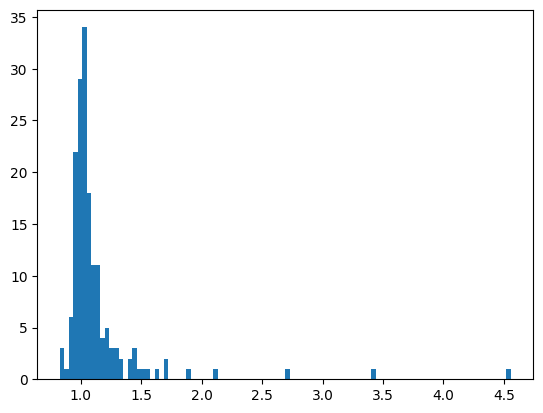

In [325]:
plt.hist(dip_s/dip, bins=100);

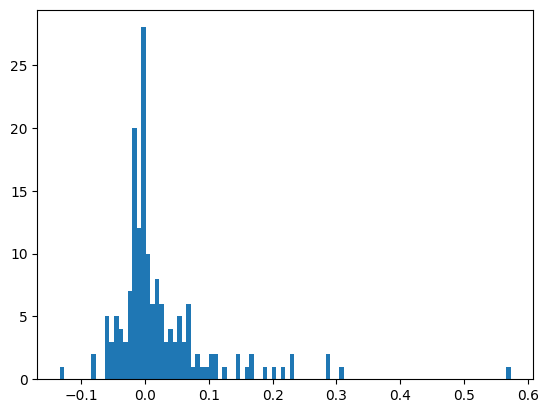

In [345]:
plt.hist(fp_s-fp, bins=100);

In [326]:
np.sum(dip_s/dip > 1)/len(dip)

0.6964285714285714

In [346]:
np.sum(fp_s-fp > 0)/len(dip)

0.4642857142857143

In [313]:
k = np.where(subIDs==172175)[0]
print(dip[k], fp[k], dip_s[k])

[0.00058712] [0.00066667] [0.00082227]


In [314]:
k = np.argmax(dip_s/dip)
print(dip[k], fp[k], dip_s[k])
print(subIDs[k])

0.0008713564283106968 0.107 0.0032921975981369212
233558


In [316]:
print(np.sum(fp < 0.01))
print(np.sum(fp_s < 0.01))

46
43


(array([98., 28., 13.,  9.,  4.,  3.,  1.,  4.,  0.,  2.,  3.,  2.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 [<matplotlib.patches.Polygon at 0x14dbd3ceafb0>])

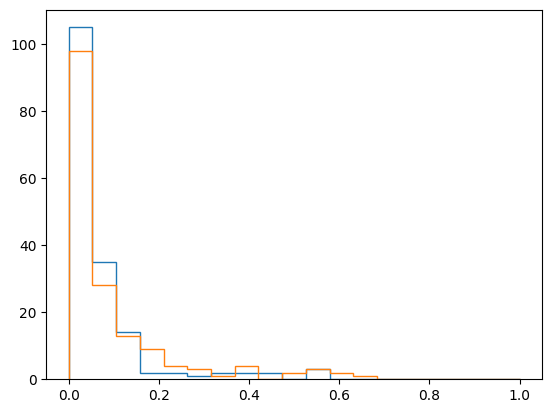

In [315]:
plt.hist(fp, histtype='step', bins=np.linspace(0, 1, 20))
plt.hist(fp_s, histtype='step', bins=np.linspace(0, 1, 20))

# gaussian mixture model

In [265]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import OPTICS

In [248]:
logFeH = logFeHs[0]
logMgFe = logMgFes[0]
X = np.vstack([logFeH, logMgFe]).T
print(X.shape)

(699458, 2)


In [264]:
%%time
bgm = BayesianGaussianMixture(n_components=5, random_state=42).fit(X)

/n/home01/abeane/venv/note/lib/python3.10/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


CPU times: user 30.8 s, sys: 520 ms, total: 31.3 s
Wall time: 31.4 s


In [271]:
bgm.predict(X)

array([0, 0, 0, ..., 1, 3, 3])

In [276]:
key = np.arange(len(X))
keysub = np.random.choice(key, 2000, replace=False)
Xsub = X[keysub]
subpredict = bgm.predict(Xsub)

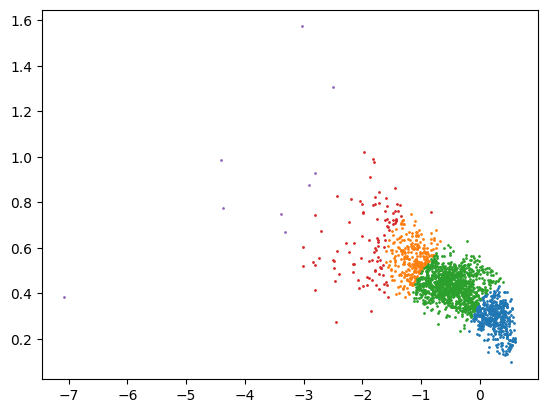

In [277]:
for i in range(10):
    ikey = subpredict == i
    plt.scatter(Xsub[ikey,0], Xsub[ikey,1], s=1)

In [270]:
%%time
opt = OPTICS(min_cluster_size=0.05, max_eps=0.01).fit(X)


KeyboardInterrupt

